## Introduction

Heart diseases is a term covering any disorder of the heart.
Heart diseases have become a major concern to deal with as studies show that the number of deaths due to heart diseases have increased significantly over the past few decades in India, in fact it has become the leading cause of death in India.

A study shows that from 1990 to 2016 the death rate due to heart diseases have increased around 34 per cent from 155.7 to 209.1 deaths per one lakh population in India.

Thus preventing Heart diseases has become more than necessary.
Good data-driven systems for predicting heart diseases can improve the entire research and prevention process, making sure that more people can live healthy lives.
This is where Machine Learning comes into play.
Machine Learning helps in predicting the Heart diseases, and the predictions made are quite accurate.

Problem Description :

A dataset is formed by taking into consideration some of the information of 779 individuals.
The problem is : based on the given information about each individual we have to calculate that whether that individual will suffer from heart disease.


In [1]:
import pandas as pd
import numpy as np

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

# tracking and versioning by mlflow
import mlflow
import mlflow.sklearn

# set experiment name
mlflow.set_experiment('bracelet')

INFO: 'bracelet' does not exist. Creating a new experiment


## Dataset :

The dataset consists of 779 individuals data.
There are 15 columns in the dataset, however the first column name is not a good parameter as far as machine learning is considered so, there are effectively 14 columns.

1.	Age : displays the age of the individual.
2.	Sex : displays the gender of the individual using the following   format : 1 = male
          0 = female.
3.	Chest-pain type : displays the type of chest-pain experienced by the individual using the following format :
           1 = typical angina
           2 = atypical angina
           3 = non - anginal pain
           4 = asymptotic
4.	Resting Blood Pressure : displays the resting blood pressure value of an individual in mmHg (unit)
5.	Serum Cholestrol : displays the serum cholestrol in mg/dl (unit)
6.	Fasting Blood Sugar : compares the fasting blood sugar value of an individual with 120mg/dl. 
   If fasting blood sugar > 120mg/dl then : 1  (true)
                                else : 0   (false)
7.	Resting ECG : 
              0 = normal
              1 = having ST-T wave abnormality
              2 = left ventricular hyperthrophy
8.	Max heart rate achieved : displays the max heart rate achieved by an individual.
9.	Exercise induced angina : 
              1 = yes
              0 = no
10.	ST depression induced by exercise relative to rest : displays the value which is integer or float.
11.	Peak exercise ST segment : 
              1 = upsloping
              2 = flat
              3 = downsloping
12.	Number of major vessels (0-3) colored by flourosopy : displays the value as integer or float.
13.	Thal : displays the thalassemia : 
              3 = normal
              6 = fixed defect
              7 = reversable defect
14.	Diagnosis of heart disease : Displays whether the individual is suffering from heart disease or not : 
              0 = absence
              1,2,3,4 = present.

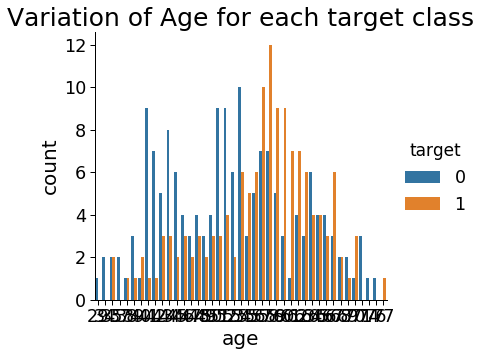

In [2]:
df = pd.read_csv('cleveland.csv', header = None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

### 1 = male, 0 = female
df.isnull().sum()

df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df['sex'] = df.sex.map({0: 'female', 1: 'male'})
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())
df['sex'] = df.sex.map({'female': 0, 'male': 1})

import matplotlib.pyplot as plt
import seaborn as sns

# distribution of target vs age 
sns.set_context("paper", font_scale = 2, rc = {"font.size": 20,"axes.titlesize": 25,"axes.labelsize": 20}) 
sns.catplot(kind = 'count', data = df, x = 'age', hue = 'target', order = df['age'].sort_values().unique())
plt.title('Variation of Age for each target class')
plt.savefig('distribution_target_vs_age.png')
plt.show() 

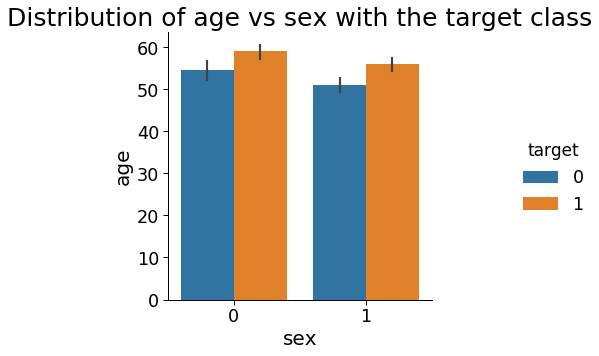

In [3]:
# barplot of age vs sex with hue = target
sns.catplot(kind = 'bar', data = df, y = 'age', x = 'sex', hue = 'target')
plt.title('Distribution of age vs sex with the target class')
plt.savefig('barplot_age_vs_sex.png')
plt.show()

In [4]:
########### data preprocessing ###########

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.preprocessing import StandardScaler as ss
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [6]:
###########   Decision Tree  ###########

with mlflow.start_run(run_name='Decision Tree'):
    
    criterion='gini'
    splitter='best'
    max_depth=None
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    from sklearn.tree import DecisionTreeClassifier
    classifier = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    from sklearn.metrics import confusion_matrix
    cm_test = confusion_matrix(y_pred, y_test)

    y_pred_train = classifier.predict(X_train)
    cm_train = confusion_matrix(y_pred_train, y_train)

    accuracy_test_set = (cm_test[0][0] + cm_test[1][1])/len(y_test)
    accuracy_training_set = (cm_train[0][0] + cm_train[1][1])/len(y_train)
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("splitter", splitter)
    mlflow.log_param("max_depth", max_depth)

    mlflow.log_metric("Accuracy", accuracy_test_set)
    mlflow.log_metric("Accuracy TrainingSet", accuracy_training_set)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    # Add tag to MLflow log
    mlflow.set_tag('model', 'Decision Tree')
    mlflow.set_tag('stage', 'playground')

    # save plot in the artifacts pool
    mlflow.log_artifact('barplot_age_vs_sex.png','analysis')

    # save plot in the artifacts pool
    mlflow.log_artifact('distribution_target_vs_age.png','analysis')
    
    mlflow.sklearn.log_model(classifier, "model")

    # Print out metrics
    print("Decision Tree model (criterion=%s, splitter=%s, max_depth=%s):" % (criterion, splitter, max_depth))
    print('  Accuracy for TestSet %s' % accuracy_test_set)
    print('  Accuracy for TrainingSet %s' % accuracy_training_set)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

Decision Tree model (criterion=gini, splitter=best, max_depth=None):
  Accuracy for TestSet 0.7704918032786885
  Accuracy for TrainingSet 1.0
  RMSE: 0.47907013758040845
  MAE: 0.22950819672131148
  R2: 0.06153846153846154


In [7]:
###########  Random Forest  ###########

with mlflow.start_run(run_name='Random Forest'):

    n_estimators = 10
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators = n_estimators)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    from sklearn.metrics import confusion_matrix
    cm_test = confusion_matrix(y_pred, y_test)

    y_pred_train = classifier.predict(X_train)
    cm_train = confusion_matrix(y_pred_train, y_train)
    
    accuracy_test_set = (cm_test[0][0] + cm_test[1][1])/len(y_test)
    accuracy_training_set = (cm_train[0][0] + cm_train[1][1])/len(y_train)
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("n_estimators", n_estimators)

    mlflow.log_metric("Accuracy", accuracy_test_set)
    mlflow.log_metric("Accuracy TrainingSet", accuracy_training_set)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    # Add tag to MLflow log
    mlflow.set_tag('model', 'Random Forest')
    mlflow.set_tag('stage', 'playground')

    # Print out metrics
    print("Random Forest (n_estimators=%s):" % (n_estimators))
    print('  Accuracy for TestSet %s' % accuracy_test_set)
    print('  Accuracy for TrainingSet %s' % accuracy_training_set)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

Random Forest (n_estimators=10):
  Accuracy for TestSet 0.7540983606557377
  Accuracy for TrainingSet 0.9752066115702479
  RMSE: 0.4958847036804647
  MAE: 0.2459016393442623
  R2: -0.005494505494505475
